# Appendix 02 - Data preprocessing: *ERA5 data*

In [1]:
import xarray as xr
import os
import numpy as np

import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping

Path for complete file:
- Temperature:      `../data/raw/ERA5/2m_temperature`
- Precipitation:    `../data/raw/ERA5/total_precipitation`

/home/jgrassi/miniconda3/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(


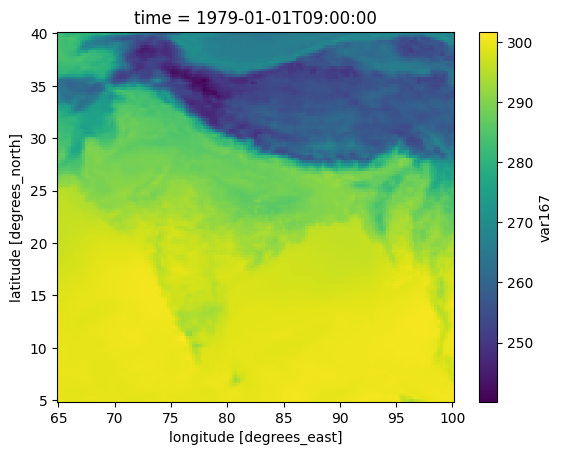

In [2]:
d = xr.open_dataset('../data/raw/ERA5/2m_temperature/temperature_1979.nc')

d.isel(time=0).var167.plot()

## STEP 1: regridding

- Define a target grid:


gridtype = lonlat   <br />
xsize    = 360      <br />
ysize    = 180      <br />
xfirst   = −179.5   <br />
xinc     = 1        <br />
yfirst   = -89.5    <br />
yinc     = 1        <br />


In [3]:
for year in np.arange(1979, 2020, 1):
    
    os.system(f'cdo remapbil,../data/preprocessed/ERA5/target_grid.txt ../data/raw/ERA5/2m_temperature/temperature_{year}.nc ../data/temp/ERA5/2m_temperature/temperature_{year}.nc')
    

os.system('cdo remapbil,../data/preprocessed/ERA5/target_grid.txt -selyear,1979/2019 ../data/raw/ERA5/total_precipitation/precipitation_1950-2023.nc ../data/temp/ERA5/total_precipitation/precipitation_temp.nc')
os.system('cdo splityear ../data/temp/ERA5/total_precipitation/precipitation_temp.nc ../data/temp/ERA5/total_precipitation/precipitation_')
os.remove('../data/temp/ERA5/total_precipitation/precipitation_temp.nc')

cdo    remapbil: Bilinear weights from lonlat (141x141) to lonlat (40x35) grid
cdo    remapbil: Processed 7256565 values from 1 variable over 365 timesteps [0.19s 66MB].
cdo    remapbil: Bilinear weights from lonlat (141x141) to lonlat (40x35) grid
cdo    remapbil: Processed 7276446 values from 1 variable over 366 timesteps [0.29s 68MB].
cdo    remapbil: Bilinear weights from lonlat (141x141) to lonlat (40x35) grid
cdo    remapbil: Processed 7256565 values from 1 variable over 365 timesteps [0.29s 68MB].
cdo    remapbil: Bilinear weights from lonlat (141x141) to lonlat (40x35) grid
cdo    remapbil: Processed 7256565 values from 1 variable over 365 timesteps [0.41s 66MB].


cdo    remapbil: Bilinear weights from lonlat (141x141) to lonlat (40x35) grid
cdo    remapbil: Processed 7256565 values from 1 variable over 365 timesteps [0.18s 68MB].
cdo    remapbil: Bilinear weights from lonlat (141x141) to lonlat (40x35) grid
cdo    remapbil: Processed 7276446 values from 1 variable over 366 timesteps [0.15s 68MB].
cdo    remapbil: Bilinear weights from lonlat (141x141) to lonlat (40x35) grid
cdo    remapbil: Processed 7256565 values from 1 variable over 365 timesteps [0.15s 68MB].
cdo    remapbil: Bilinear weights from lonlat (141x141) to lonlat (40x35) grid
cdo    remapbil: Processed 7256565 values from 1 variable over 365 timesteps [0.19s 66MB].
cdo    remapbil: Bilinear weights from lonlat (141x141) to lonlat (40x35) grid
cdo    remapbil: Processed 7256565 values from 1 variable over 365 timesteps [0.15s 60MB].
cdo    remapbil: Bilinear weights from lonlat (141x141) to lonlat (40x35) grid
cdo    remapbil: Processed 7276446 values from 1 variable over 366 time

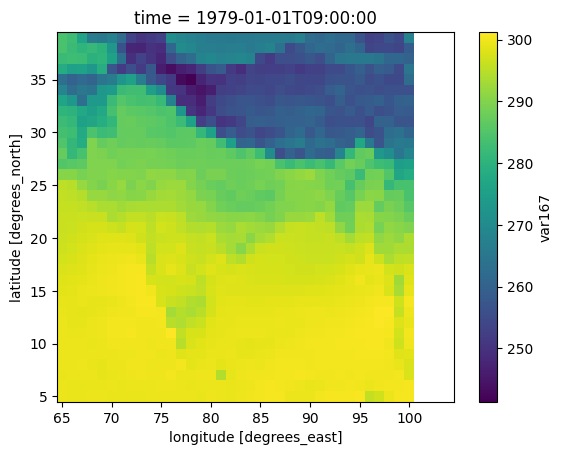

In [4]:
d = xr.open_dataset('../data/temp/ERA5/2m_temperature/temperature_1979.nc')

d.isel(time=0).var167.plot()

In [5]:
temperature_dataset = xr.open_mfdataset('../data/temp/ERA5/2m_temperature/*.nc')
precipitation_dataset = xr.open_mfdataset('../data/temp/ERA5/total_precipitation/*.nc')

In [6]:
world_boundary_file   = '../data/raw/external/GADM41_WORLD.gpkg'
world_boundary = gpd.read_file(world_boundary_file, layer='ADM_1')

In [7]:
def clean_cut(dataset_ori, boundary):

    # Converting calendar and removing useless dimensions
    dataset_ori = dataset_ori.convert_calendar('noleap')
    dataset_ori = dataset_ori.drop_dims('bnds')

    # Setting the datasets for masking
    dataset_ori.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    dataset_ori.rio.write_crs("epsg:4326", inplace=True)

    # Masking the datasets
    dataset_ori = dataset_ori.rio.clip(boundary.geometry.apply(mapping), boundary.crs, drop=True)

    return dataset_ori
    

In [8]:
dataset_t2m_ori = clean_cut(temperature_dataset, world_boundary).rolling(time=15, center=True).mean().sel(time=slice('1980','2011'))
dataset_tp_ori = clean_cut(precipitation_dataset, world_boundary).rolling(time=15, center=True).mean().sel(time=slice('1980','2011'))

In [9]:
dataset_t2m_ori.to_netcdf('../data/preprocessed/ERA5/2m_temperature/temperature_preprocessed.nc')
dataset_tp_ori.to_netcdf('../data/preprocessed/ERA5/total_precipitation/precipitation_preprocessed.nc')